<a href="https://colab.research.google.com/github/rahiakela/machine-learning-research-and-practice/blob/main/ai-powered-search/13-semantic-search/03_semantic_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Semantic Search

In [ ]:
!pip install sentence_transformers
!pip install nmslib

In [ ]:
!pip install nmslib

In [ ]:
!wget https://github.com/treygrainger/ai-powered-search/raw/main/docker/data-science/notebooks/densevectors/outdoors.py

In [4]:
from sentence_transformers import SentenceTransformer
from sentence_transformers import util as STutil

import spacy
from spacy.matcher import Matcher

import nmslib

from outdoors import *
from plotnine import *

import pandas as pd
import pickle
import json
import tqdm
from IPython.display import display,HTML
pd.set_option('display.max_rows', 1000)

##Load Dataset

In [5]:
!rm -rf outdoors

In [6]:
#outdoors
!mkdir -p outdoors

!git clone https://github.com/ai-powered-search/outdoors.git
!cd outdoors && cat outdoors.tgz.part_* > outdoors.tgz
!cd outdoors && mkdir -p 'data/outdoors/' && tar -xvf outdoors.tgz -C 'data/outdoors/'

Cloning into 'outdoors'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 71 (delta 0), reused 0 (delta 0), pack-reused 70
Receiving objects: 100% (71/71), 1005.42 MiB | 20.44 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Updating files: 100% (23/23), done.
README.md
concepts.pickle
._guesses.csv
guesses.csv
._guesses_all.json
guesses_all.json
outdoors_concepts.pickle
outdoors_embeddings.pickle
._outdoors_golden_answers.csv
outdoors_golden_answers.csv
._outdoors_golden_answers.xlsx
outdoors_golden_answers.xlsx
._outdoors_golden_answers_20210130.csv
outdoors_golden_answers_20210130.csv
outdoors_labels.pickle
outdoors_question_answering_contexts.json
outdoors_questionanswering_test_set.json
outdoors_questionanswering_train_set.json
._posts.csv
posts.csv
predicates.pickle
pull_aips_dependency.py
._question-answer-seed-contexts.csv
question-answer-seed-contexts.csv
question-answer-squad2-guesses.csv
._roberta-base-squad2-outdoors
roberta

In [ ]:
# let's transform the the outdoors/posts.csv file into a useable dataframe
outdoors_dataframe = cleanDataset('outdoors/data/outdoors/posts.csv')

In [8]:
print(len(outdoors_dataframe))

19585


##Loading model

In [ ]:
stsb = SentenceTransformer("roberta-base-nli-stsb-mean-tokens")

In [10]:
print(stsb)

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': True}) with Transformer model: RobertaModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)


##Getting Embeddings

In [12]:
embeddings_pickle_path = "outdoors/data/outdoors/outdoors_semantic_search_embeddings.pickle"

In [13]:
def get_embeddings(sentences, load_from_cache=True):
  if not load_from_cache:
    embeddings = stsb.encode(sentences, convert_to_tensor=True)
    with open(embeddings_pickle_path, "wb") as fd:
      pickle.dump(embeddings, fd)
  else:
    with open(embeddings_pickle_path, "rb") as fd:
      embeddings = pickle.load(fd)
  return embeddings

In [14]:
# Encode the titles into embeddings
titles = list(filter(None, list(outdoors_dataframe["title"])))
embeddings = get_embeddings(titles, load_from_cache=False)

print(f"Number of embeddings: {len(embeddings)}")
print(f"Dimensions per embedding: {len(embeddings[0])}")

Number of embeddings: 5331
Dimensions per embedding: 768


##Calculate similarity

In [15]:
# let's find the pairs with the highest cosine similarity scores
similarities = STutil.pytorch_cos_sim(embeddings[0:100], embeddings[0:100])
print(f"The shape of the resulting similarities: {similarities.shape}")

The shape of the resulting similarities: torch.Size([100, 100])


In [17]:
a_phrases = []
b_phrases = []
scores = []

for a in range(len(similarities) - 1):
  for b in range(a + 1, len(similarities)):
    a_phrases.append(titles[a])
    b_phrases.append(titles[b])
    scores.append(float(similarities[a][b]))

comparisons_df = pd.DataFrame({"phrase a": a_phrases, "phrase b": b_phrases, "score": scores, "name": "similarity"})
comparisons_df = comparisons_df.sort_values(by=["score"], ascending=False, ignore_index=True)
comparisons_df["idx"] = range(len(comparisons_df))
comparisons_df[comparisons_df["score"] > .8]

,phrase a,phrase b,score,name,idx
0,How do I recognize if someone is suffering fro...,How should I treat hypothermia?,0.846395,similarity,0
1,How should I treat poison ivy?,What can I do to prevent getting poison ivy?,0.811995,similarity,1
2,What is the difference between the different t...,What is the difference between camber and rock...,0.800817,similarity,2


##Similarity distribution

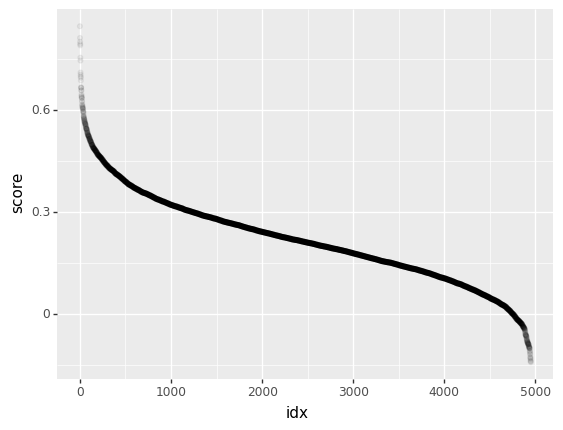

{<ggplot: (8348998306597)>}

In [18]:
# let’s look at the distribution of the resulting similarity scores
{
    ggplot(comparisons_df, aes("idx", "score"))
    + geom_point(alpha=0.05)
}

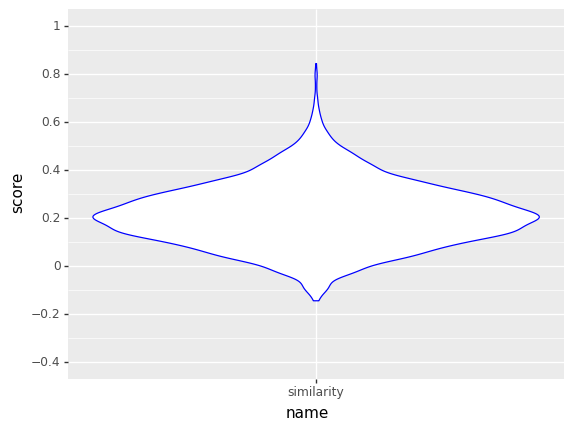

{<ggplot: (8348990769140)>}

In [19]:
# let’s look at the distribution of the resulting similarity scores
{
    ggplot(comparisons_df, aes("name", "score"))
    + geom_violin(color="blue")
    + scale_y_continuous(limits=[-0.4,1.0], breaks=[-0.4,-0.2,0,0.2,0.4,0.6,0.8,1.0])
}

##Nearest-Neighbor search

In [ ]:
# let's create HNSW index from all 12,375 embeddings and then performs an example search for concepts similar to the term 'bag'

# initialize a new index, using a HNSW index on Cosine Similarity
index = nmslib.init(method="hnsw", space="cosinesimil")
index.addDataPointBatch(embeddings)
index.createIndex(print_progress=True)

# Example query for the new index.  The 25th embedding is the term 'bag'
ids, distances = index.knnQuery(embeddings[25], k=10)
matches = [labels[phrases[idx]].lower() for idx in ids]
print(matches)

['bag', 'bag ratings', 'bag cover', 'bag liner', 'garbage bags', 'wag bags', 'bag cooking', 'airbag', 'paper bag', 'tea bags']


In [ ]:
# Example query for the new index.  The 21th embedding is the term 'work'
ids, distances = index.knnQuery(embeddings[21], k=10)
matches = [labels[phrases[idx]].lower() for idx in ids]
print(matches)

['working', 'working', 'does work', 'has worked', 'workplace', 'kept working', 'workers', 'leather work', 'job', 'homework']


In [ ]:
# let's create a method that accepts any query whether or not it’s already in our dictionary
def semantic_suggest(query, k=20):
  matches = []
  embeddings = stsb.encode([query], convert_to_tensor=True)
  ids, distances = index.knnQuery(embeddings[0].cpu().numpy(), k=k)
  for id in range(len(ids)):
    text = phrases[ids[id]]
    distance = 1.0 - distances[id]
    if distance > 0.75:
      matches.append((text, distance))
  if not len(matches):
    matches.append((phrases[ids[1]], 1.0 - distances[id]))
  return matches

In [ ]:
#from IPython.display import display,HTML

def print_labels(prefix,matches):
  display(HTML('<h4>Results for: <em>'+prefix+'</em></h4>'))
  for l,d in matches:
    if l in labels.keys():
      l = labels[l].lower()
    print(l + '\t' + str(d))

def autocomplete(prefix):
  matches = semantic_suggest(prefix)
  print_labels(prefix,matches)

In [ ]:
autocomplete("mountain hike")

mountain hike	1.0
mountain hiking	0.9756487011909485
mountain trail	0.8470598459243774
mountain guides	0.7870421409606934
mountain terrain	0.7799180746078491
mountain climbing	0.7756213545799255
mountain ridge	0.7680721282958984
winter hikes	0.7541308403015137


In [ ]:
autocomplete("campfire")

campfire	0.9999998807907104
camp fire	0.9566245079040527
campfire impacts	0.928297758102417
camping fuels	0.8655523657798767
camping stoves	0.8239545822143555
camp stove	0.7969685792922974
cooking fires	0.7753305435180664
campground	0.7744450569152832
fireplace	0.7649710178375244
camping area	0.7596511840820312
have camped	0.7553195953369141


In [ ]:
autocomplete("dehyd")

dehydrated	0.9417487382888794
dehydration	0.9317408800125122
rehydration	0.8525168299674988
dehydrator	0.8514857292175293
hydration	0.8362183570861816
hydrating	0.8358256220817566
rehydrating	0.8222473859786987
hydrated	0.8123505115509033
hydration pack	0.7883821725845337
hydration system	0.7768827676773071


In [ ]:
autocomplete("compa")

comp	0.863274335861206
compact	0.8295656442642212
compiled	0.8032784461975098
compost	0.7929490804672241
compass	0.7862532138824463
competitors	0.7782407999038696
competence	0.7651965618133545
compactor	0.7587993741035461
compare	0.7551058530807495


In [ ]:
autocomplete("excer")

excel	0.5212134718894958
